# RetailGenius Customer Churn Prediction

## EPITA - AI Project Methodology 2025-2026

This notebook provides an end-to-end exploration and implementation of the customer churn prediction project.

### Table of Contents
1. [Setup and Imports](#1.-Setup-and-Imports)
2. [Data Loading and Exploration](#2.-Data-Loading-and-Exploration)
3. [Data Preparation](#3.-Data-Preparation)
4. [Feature Engineering](#4.-Feature-Engineering)
5. [Model Training with MLflow](#5.-Model-Training-with-MLflow)
6. [Model Evaluation](#6.-Model-Evaluation)
7. [SHAP Analysis (Explainable AI)](#7.-SHAP-Analysis)
8. [Inference](#8.-Inference)

## 1. Setup and Imports

In [1]:
# Standard library imports
import os
import sys
import warnings
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)

# Optional: XGBoost and LightGBM
try:
    import xgboost as xgb
    HAS_XGBOOST = True
    print("XGBoost available")
except ImportError:
    HAS_XGBOOST = False
    print("XGBoost not available - will skip. Install with: brew install libomp && pip install xgboost")

try:
    import lightgbm as lgb
    HAS_LIGHTGBM = True
    print("LightGBM available")
except ImportError:
    HAS_LIGHTGBM = False
    print("LightGBM not available - will skip. Install with: pip install lightgbm")

# MLflow
import mlflow
import mlflow.sklearn
if HAS_XGBOOST:
    import mlflow.xgboost
if HAS_LIGHTGBM:
    import mlflow.lightgbm

# SHAP
import shap

# Utilities
import joblib

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print(f"\nPython version: {sys.version}")
print(f"MLflow version: {mlflow.__version__}")
print(f"SHAP version: {shap.__version__}")
print("\nSetup complete!")

XGBoost available
LightGBM available


/Users/ebotfabien/Desktop/AI_Project_Methodology/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Python version: 3.9.6 (default, Feb  3 2024, 15:58:27) 
[Clang 15.0.0 (clang-1500.3.9.4)]
MLflow version: 3.1.4
SHAP version: 0.49.1

Setup complete!


## 2. Data Loading and Exploration

In [2]:
# Load the dataset from the correct sheet
DATA_PATH = '../data/raw/E Commerce Dataset.xlsx'

# Load Excel file and check sheets
xl = pd.ExcelFile(DATA_PATH)
print(f"Available sheets: {xl.sheet_names}")

# Load from 'E Comm' sheet (the one with actual data)
df = pd.read_excel(DATA_PATH, sheet_name='E Comm')

print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Available sheets: ['Data Dict', 'E Comm']

Dataset shape: (5630, 20)

Columns: ['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier', 'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']


In [3]:
# Display first few rows
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [4]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [5]:
# Statistical summary
df.describe()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,52815.500000,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.223030
std,1625.385339,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.207036
min,50001.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,52815.500000,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.280000
75%,54222.750000,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.392500
max,55630.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,324.990000


In [6]:
# Check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
print("Columns with missing values:")
missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)

Columns with missing values:


,Missing Count,Missing %
DaySinceLastOrder,307,5.452931
OrderAmountHikeFromlastYear,265,4.706927
Tenure,264,4.689165
OrderCount,258,4.582593
CouponUsed,256,4.547069
HourSpendOnApp,255,4.529307
WarehouseToHome,251,4.458259


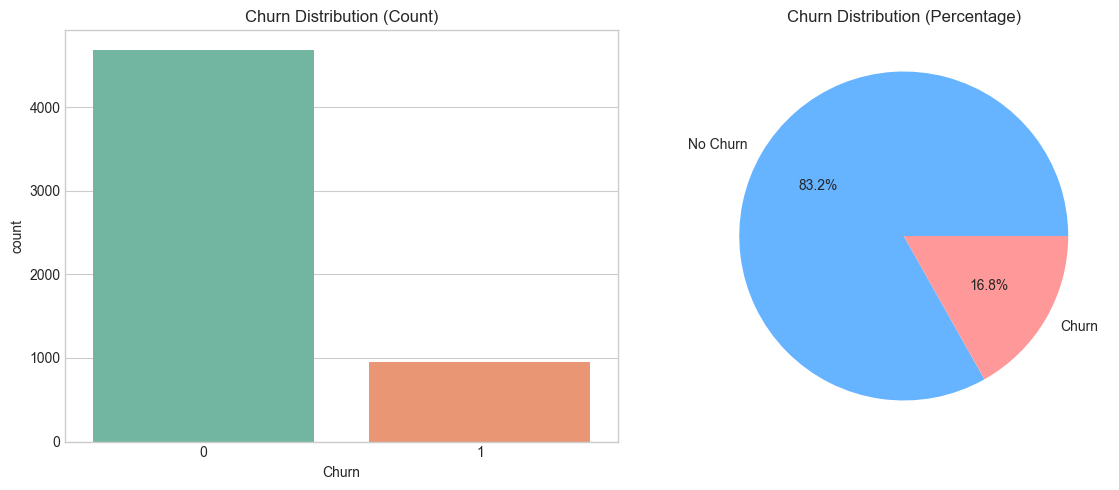


Churn Rate: 16.84%


In [7]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
sns.countplot(data=df, x='Churn', ax=axes[0], palette='Set2')
axes[0].set_title('Churn Distribution (Count)')

# Pie chart
churn_counts = df['Churn'].value_counts()
axes[1].pie(churn_counts.values, labels=['No Churn', 'Churn'], 
            autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
axes[1].set_title('Churn Distribution (Percentage)')

plt.tight_layout()
plt.savefig('../reports/figures/churn_distribution.png', dpi=300)
plt.show()

print(f"\nChurn Rate: {df['Churn'].mean():.2%}")

## 3. Data Preparation

In [8]:
# Define feature categories based on actual column names
NUMERICAL_FEATURES = [
    'Tenure', 'WarehouseToHome', 'HourSpendOnApp',
    'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress',
    'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed',
    'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'
]

CATEGORICAL_FEATURES = [
    'PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode',
    'Gender', 'PreferedOrderCat', 'MaritalStatus'
]

TARGET = 'Churn'
ID_COLUMN = 'CustomerID'

# Verify columns exist
print("Numerical features found:", [c for c in NUMERICAL_FEATURES if c in df.columns])
print("Categorical features found:", [c for c in CATEGORICAL_FEATURES if c in df.columns])

Numerical features found: ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
Categorical features found: ['PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']


In [9]:
# Create a copy for processing
df_clean = df.copy()

# Remove duplicates
initial_rows = len(df_clean)
df_clean = df_clean.drop_duplicates()
print(f"Removed {initial_rows - len(df_clean)} duplicate rows")

# Handle missing values in numerical columns
for col in NUMERICAL_FEATURES:
    if col in df_clean.columns:
        missing = df_clean[col].isnull().sum()
        if missing > 0:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"Filled {missing} missing values in '{col}' with median: {median_val:.2f}")

# Handle missing values in categorical columns
for col in CATEGORICAL_FEATURES:
    if col in df_clean.columns:
        missing = df_clean[col].isnull().sum()
        if missing > 0:
            mode_val = df_clean[col].mode()[0]
            df_clean[col] = df_clean[col].fillna(mode_val)
            print(f"Filled {missing} missing values in '{col}' with mode: {mode_val}")

print(f"\nFinal dataset shape: {df_clean.shape}")

Removed 0 duplicate rows
Filled 264 missing values in 'Tenure' with median: 9.00
Filled 251 missing values in 'WarehouseToHome' with median: 14.00
Filled 255 missing values in 'HourSpendOnApp' with median: 3.00
Filled 265 missing values in 'OrderAmountHikeFromlastYear' with median: 15.00
Filled 256 missing values in 'CouponUsed' with median: 1.00
Filled 258 missing values in 'OrderCount' with median: 2.00
Filled 307 missing values in 'DaySinceLastOrder' with median: 3.00

Final dataset shape: (5630, 20)


In [10]:
# Save cleaned data
df_clean.to_csv('../data/interim/cleaned_data.csv', index=False)
print(f"Saved cleaned data: {df_clean.shape}")

Saved cleaned data: (5630, 20)


## 4. Feature Engineering

In [11]:
# Create derived features
df_features = df_clean.copy()

# Average cashback per order
df_features['AvgCashbackPerOrder'] = df_features['CashbackAmount'] / df_features['OrderCount'].replace(0, 1)

# Engagement score
df_features['EngagementScore'] = df_features['HourSpendOnApp'] * df_features['NumberOfDeviceRegistered']

# Activity level
df_features['ActivityLevel'] = df_features['OrderCount'] / df_features['DaySinceLastOrder'].replace(0, 1)

# Coupon usage rate
df_features['CouponUsageRate'] = df_features['CouponUsed'] / df_features['OrderCount'].replace(0, 1)

print("Created derived features:")
print("- AvgCashbackPerOrder")
print("- EngagementScore")
print("- ActivityLevel")
print("- CouponUsageRate")
print(f"\nTotal features now: {len(df_features.columns)}")

Created derived features:
- AvgCashbackPerOrder
- EngagementScore
- ActivityLevel
- CouponUsageRate

Total features now: 24


In [12]:
# Encode categorical variables
encoders = {}

for col in CATEGORICAL_FEATURES:
    if col in df_features.columns:
        encoder = LabelEncoder()
        df_features[col] = df_features[col].astype(str)
        df_features[col] = encoder.fit_transform(df_features[col])
        encoders[col] = encoder
        print(f"Encoded '{col}' with {len(encoder.classes_)} classes: {list(encoder.classes_)}")

# Save encoders
joblib.dump(encoders, '../models/encoders.joblib')
print("\nEncoders saved!")

Encoded 'PreferredLoginDevice' with 3 classes: ['Computer', 'Mobile Phone', 'Phone']
Encoded 'CityTier' with 3 classes: ['1', '2', '3']
Encoded 'PreferredPaymentMode' with 7 classes: ['CC', 'COD', 'Cash on Delivery', 'Credit Card', 'Debit Card', 'E wallet', 'UPI']
Encoded 'Gender' with 2 classes: ['Female', 'Male']
Encoded 'PreferedOrderCat' with 6 classes: ['Fashion', 'Grocery', 'Laptop & Accessory', 'Mobile', 'Mobile Phone', 'Others']
Encoded 'MaritalStatus' with 3 classes: ['Divorced', 'Married', 'Single']

Encoders saved!


In [13]:
# Prepare features and target
feature_cols = [col for col in df_features.columns if col not in [TARGET, ID_COLUMN]]
X = df_features[feature_cols]
y = df_features[TARGET]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({len(feature_cols)}): {feature_cols}")

Features shape: (5630, 22)
Target shape: (5630,)

Feature columns (22): ['Tenure', 'PreferredLoginDevice', 'CityTier', 'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount', 'AvgCashbackPerOrder', 'EngagementScore', 'ActivityLevel', 'CouponUsageRate']


In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nChurn rate - Train: {y_train.mean():.2%}, Test: {y_test.mean():.2%}")

Training set: (4504, 22)
Test set: (1126, 22)

Churn rate - Train: 16.83%, Test: 16.87%


In [15]:
# Scale numerical features
scaler = StandardScaler()

# Get all numerical columns (original + derived)
numerical_cols = NUMERICAL_FEATURES + ['AvgCashbackPerOrder', 'EngagementScore', 'ActivityLevel', 'CouponUsageRate']
numerical_cols = [col for col in numerical_cols if col in X_train.columns]

print(f"Scaling {len(numerical_cols)} numerical columns")

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Save scaler
joblib.dump(scaler, '../models/scaler.joblib')

print("Features scaled and scaler saved!")

Scaling 16 numerical columns
Features scaled and scaler saved!


In [16]:
# Save processed data
X_train_scaled.to_csv('../data/processed/X_train.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

# Save feature names
with open('../data/processed/feature_names.txt', 'w') as f:
    f.write('\n'.join(X_train_scaled.columns.tolist()))

print("Saved processed data to data/processed/")

Saved processed data to data/processed/


## 5. Model Training with MLflow

In [17]:
# Set up MLflow
mlflow.set_tracking_uri('mlruns')
mlflow.set_experiment('RetailGenius_Churn_Prediction')

print("MLflow experiment set up successfully!")

2025/12/25 08:07:55 INFO mlflow.tracking.fluent: Experiment with name 'RetailGenius_Churn_Prediction' does not exist. Creating a new experiment.


MLflow experiment set up successfully!


In [18]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model and return metrics."""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    return metrics, y_pred, y_pred_proba

In [19]:
# Model configurations - only include available models
models = {
    'random_forest': {
        'model': RandomForestClassifier(
            n_estimators=100, max_depth=10, min_samples_split=5,
            min_samples_leaf=2, random_state=RANDOM_STATE, n_jobs=-1
        ),
        'params': {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}
    }
}

# Add XGBoost if available
if HAS_XGBOOST:
    models['xgboost'] = {
        'model': xgb.XGBClassifier(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE,
            use_label_encoder=False, eval_metric='logloss'
        ),
        'params': {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8}
    }

# Add LightGBM if available
if HAS_LIGHTGBM:
    models['lightgbm'] = {
        'model': lgb.LGBMClassifier(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            num_leaves=31, random_state=RANDOM_STATE, verbose=-1
        ),
        'params': {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'num_leaves': 31}
    }

print(f"Models to train: {list(models.keys())}")

Models to train: ['random_forest', 'xgboost', 'lightgbm']


In [20]:
# Train all models with MLflow tracking
results = {}
best_model = None
best_score = 0
best_model_name = None

for model_name, model_config in models.items():
    print(f"\n{'='*50}")
    print(f"Training: {model_name}")
    print(f"{'='*50}")
    
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_params(model_config['params'])
        
        # Train model
        model = model_config['model']
        model.fit(X_train_scaled, y_train)
        
        # Evaluate
        metrics, y_pred, y_pred_proba = evaluate_model(model, X_test_scaled, y_test)
        
        # Log metrics
        for metric_name, metric_value in metrics.items():
            mlflow.log_metric(metric_name, metric_value)
            print(f"  {metric_name}: {metric_value:.4f}")
        
        # Log model
        if model_name == 'random_forest':
            mlflow.sklearn.log_model(model, 'model')
        elif model_name == 'xgboost' and HAS_XGBOOST:
            mlflow.xgboost.log_model(model, 'model')
        elif model_name == 'lightgbm' and HAS_LIGHTGBM:
            mlflow.lightgbm.log_model(model, 'model')
        
        # Save model locally
        joblib.dump(model, f'../models/{model_name}_model.joblib')
        
        # Store results
        results[model_name] = {
            'model': model,
            'metrics': metrics,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        # Track best model
        if metrics['f1_score'] > best_score:
            best_score = metrics['f1_score']
            best_model = model
            best_model_name = model_name

print(f"\n\n{'='*50}")
print(f"Best Model: {best_model_name} (F1 Score: {best_score:.4f})")
print(f"{'='*50}")


Training: random_forest


2025/12/25 08:07:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  accuracy: 0.9396
  precision: 0.9357
  recall: 0.6895
  f1_score: 0.7939
  roc_auc: 0.9805


2025/12/25 08:08:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/25 08:08:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Training: xgboost
  accuracy: 0.9591
  precision: 0.9444
  recall: 0.8053
  f1_score: 0.8693
  roc_auc: 0.9918


2025/12/25 08:08:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training: lightgbm


2025/12/25 08:08:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  accuracy: 0.9663
  precision: 0.9368
  recall: 0.8579
  f1_score: 0.8956
  roc_auc: 0.9930


2025/12/25 08:08:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.




Best Model: lightgbm (F1 Score: 0.8956)


In [21]:
# Save best model
joblib.dump(best_model, '../models/best_model.joblib')
print(f"Best model ({best_model_name}) saved to models/best_model.joblib")

Best model (lightgbm) saved to models/best_model.joblib


## 6. Model Evaluation

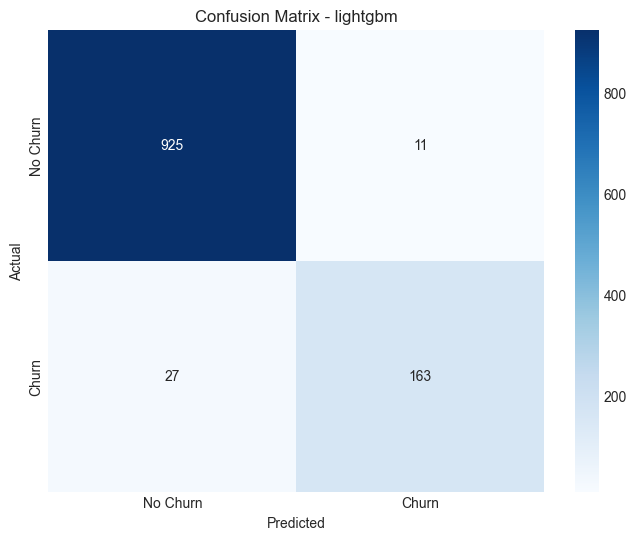


Classification Report:
              precision    recall  f1-score   support

    No Churn       0.97      0.99      0.98       936
       Churn       0.94      0.86      0.90       190

    accuracy                           0.97      1126
   macro avg       0.95      0.92      0.94      1126
weighted avg       0.97      0.97      0.97      1126



In [22]:
# Confusion matrix for best model
best_results = results[best_model_name]
cm = confusion_matrix(y_test, best_results['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.savefig('../reports/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, best_results['predictions'], target_names=['No Churn', 'Churn']))

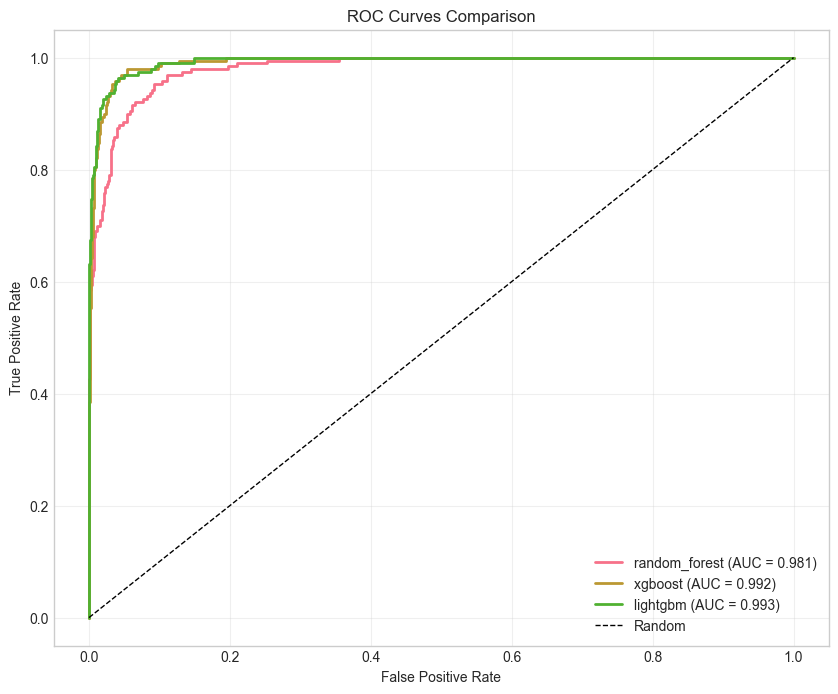

In [23]:
# ROC curves for all models
plt.figure(figsize=(10, 8))

for model_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    auc_score = result['metrics']['roc_auc']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('../reports/figures/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

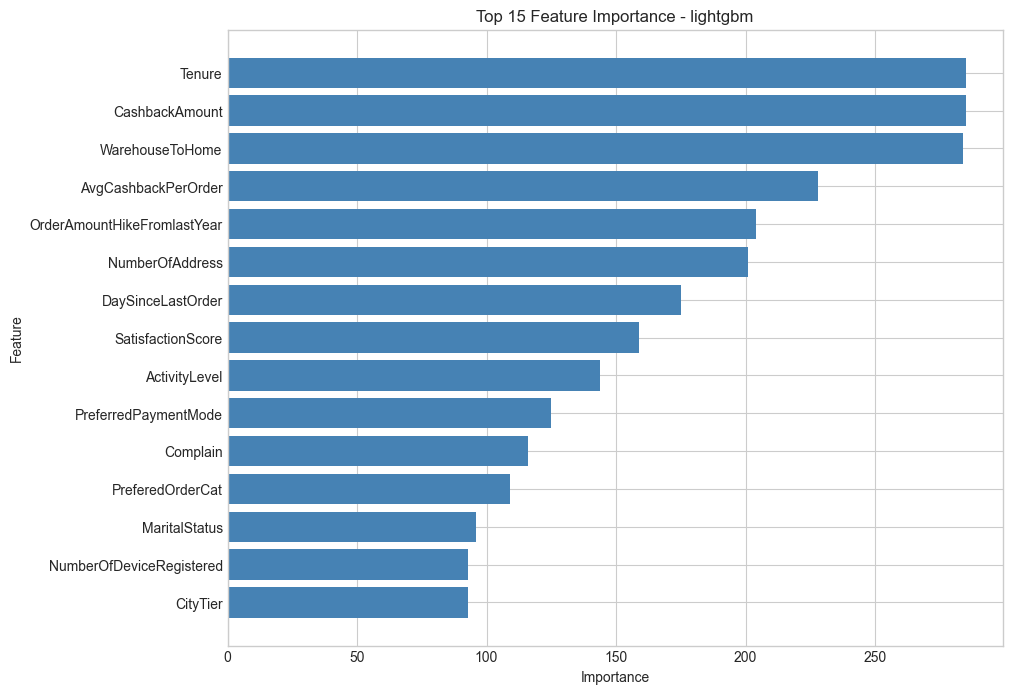

In [24]:
# Feature importance
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True).tail(15)
    
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.savefig('../reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

In [25]:
# Model comparison summary
comparison_df = pd.DataFrame({
    model_name: result['metrics'] 
    for model_name, result in results.items()
}).T

print("Model Comparison:")
comparison_df.style.highlight_max(axis=0, color='lightgreen')

Model Comparison:


,accuracy,precision,recall,f1_score,roc_auc
random_forest,0.939609,0.935714,0.689474,0.793939,0.980527
xgboost,0.959147,0.944444,0.805263,0.869318,0.991824
lightgbm,0.966252,0.936782,0.857895,0.895604,0.993011


## 7. SHAP Analysis (Explainable AI)

### Part 3 of the Graded Project

In [26]:
# Initialize SHAP
shap.initjs()

# Create TreeExplainer
print("Creating SHAP TreeExplainer...")
X_background = X_train_scaled.sample(n=100, random_state=RANDOM_STATE)
explainer = shap.TreeExplainer(best_model, X_background)
print("Explainer created successfully!")

Creating SHAP TreeExplainer...
Explainer created successfully!


In [27]:
# Compute SHAP values
print("Computing SHAP values (this may take a minute)...")
X_sample = X_test_scaled.sample(n=min(500, len(X_test_scaled)), random_state=RANDOM_STATE)
shap_values = explainer(X_sample)
print(f"SHAP values computed for {len(X_sample)} samples!")
print(f"SHAP values shape: {shap_values.shape}")

Computing SHAP values (this may take a minute)...
SHAP values computed for 500 samples!
SHAP values shape: (500, 22)


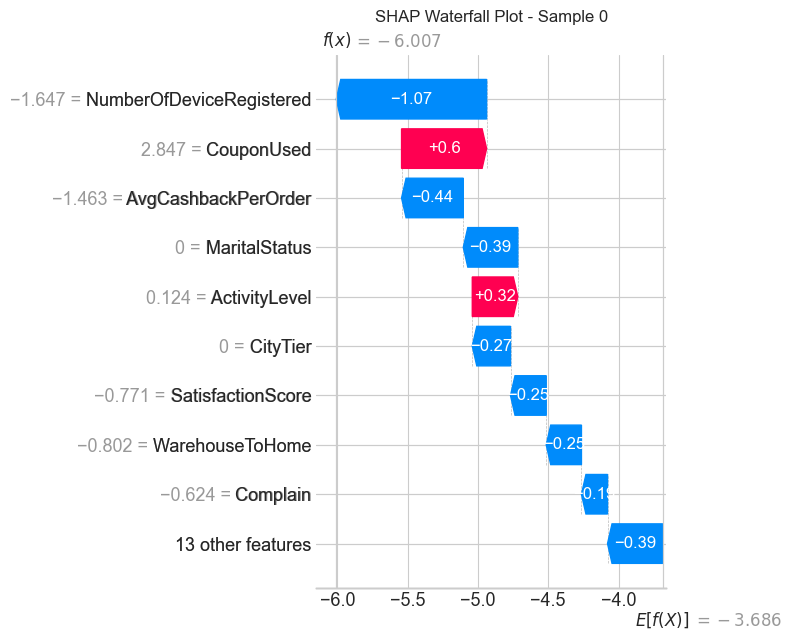

In [28]:
# Waterfall plot for a specific sample
sample_idx = 0

plt.figure(figsize=(12, 8))
if len(shap_values.shape) == 3:
    shap.plots.waterfall(shap_values[sample_idx, :, 1], show=False)
else:
    shap.plots.waterfall(shap_values[sample_idx], show=False)
plt.title(f'SHAP Waterfall Plot - Sample {sample_idx}')
plt.tight_layout()
plt.savefig(f'../reports/figures/shap_waterfall_sample_{sample_idx}.png', dpi=300, bbox_inches='tight')
plt.show()

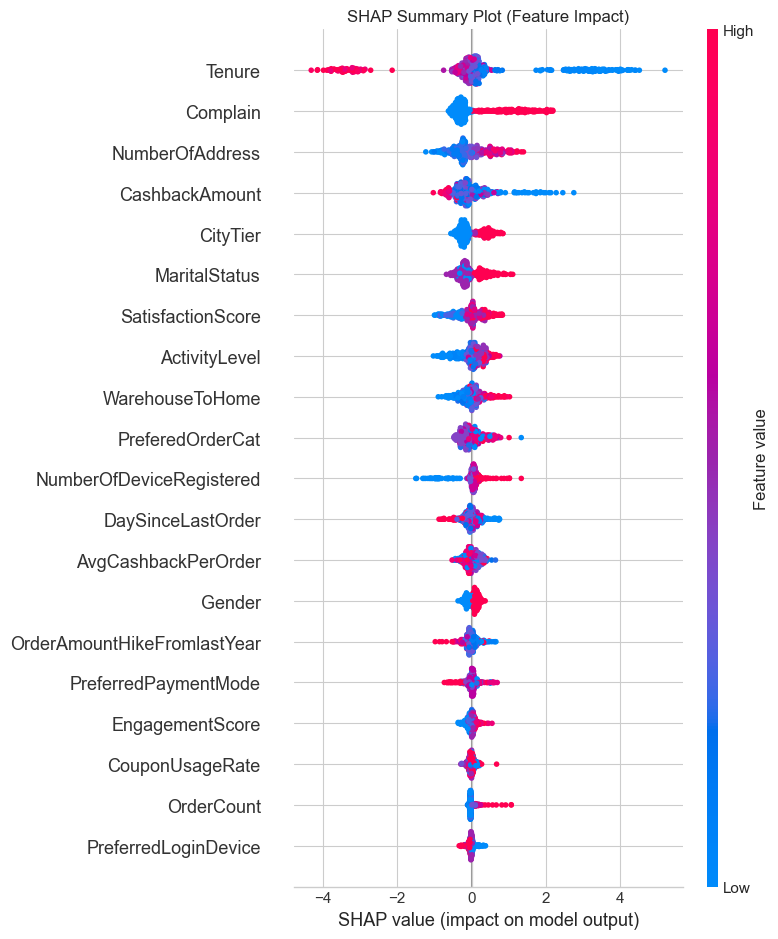

In [29]:
# Summary plot (dot) - shows all features for all samples
plt.figure(figsize=(12, 8))
if len(shap_values.shape) == 3:
    shap.summary_plot(shap_values.values[:, :, 1], X_sample, show=False)
else:
    shap.summary_plot(shap_values.values, X_sample, show=False)
plt.title('SHAP Summary Plot (Feature Impact)')
plt.tight_layout()
plt.savefig('../reports/figures/shap_summary_dot.png', dpi=300, bbox_inches='tight')
plt.show()

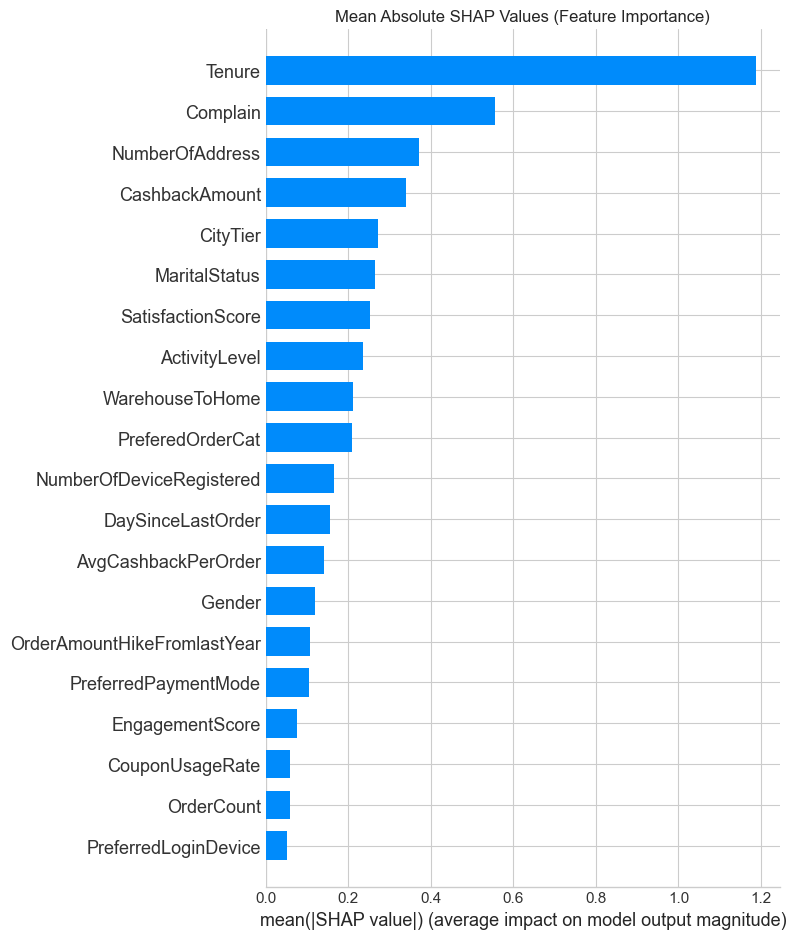

In [30]:
# Mean SHAP values (bar plot) - feature importance
plt.figure(figsize=(12, 8))
if len(shap_values.shape) == 3:
    shap.summary_plot(shap_values.values[:, :, 1], X_sample, plot_type='bar', show=False)
else:
    shap.summary_plot(shap_values.values, X_sample, plot_type='bar', show=False)
plt.title('Mean Absolute SHAP Values (Feature Importance)')
plt.tight_layout()
plt.savefig('../reports/figures/shap_mean_values.png', dpi=300, bbox_inches='tight')
plt.show()

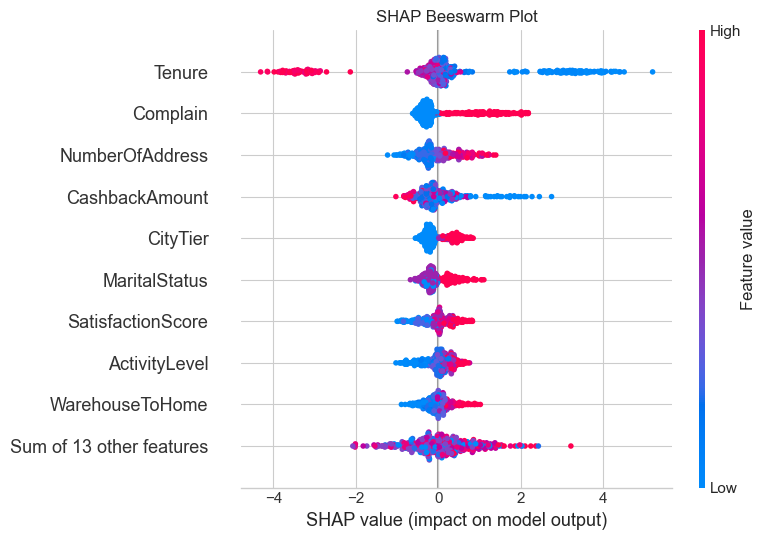

In [31]:
# Beeswarm plot
plt.figure(figsize=(12, 8))
if len(shap_values.shape) == 3:
    shap.plots.beeswarm(shap_values[:, :, 1], show=False)
else:
    shap.plots.beeswarm(shap_values, show=False)
plt.title('SHAP Beeswarm Plot')
plt.tight_layout()
plt.savefig('../reports/figures/shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 2000x300 with 0 Axes>

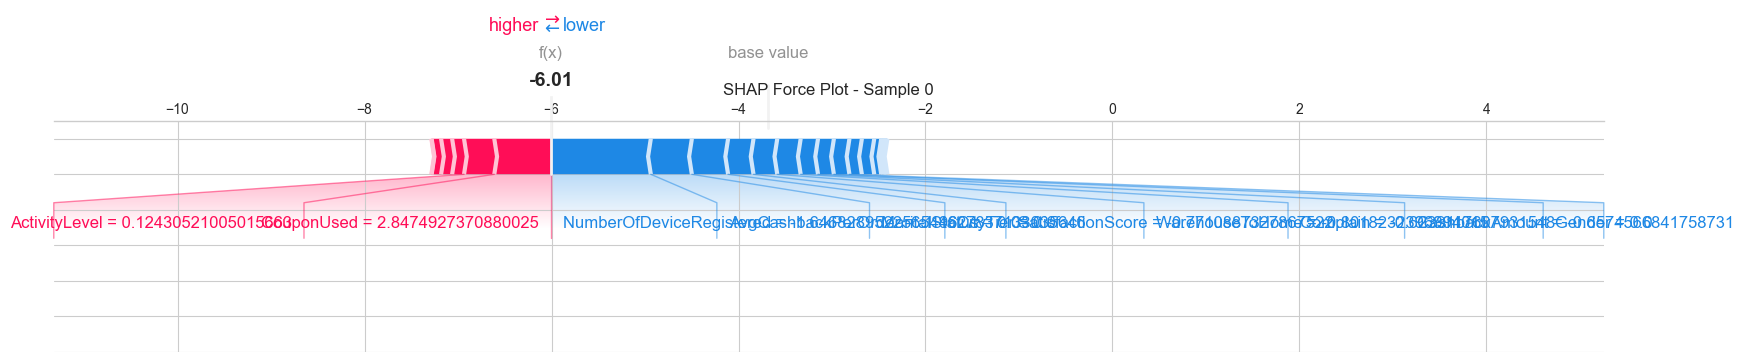

In [32]:
# Force plot for a specific sample
sample_idx = 0

if hasattr(explainer, 'expected_value'):
    if isinstance(explainer.expected_value, np.ndarray):
        expected_value = explainer.expected_value[1]
    else:
        expected_value = explainer.expected_value
else:
    expected_value = shap_values.base_values[sample_idx]
    if isinstance(expected_value, np.ndarray):
        expected_value = expected_value[1]

if len(shap_values.shape) == 3:
    sample_shap = shap_values.values[sample_idx, :, 1]
else:
    sample_shap = shap_values.values[sample_idx]

plt.figure(figsize=(20, 3))
shap.force_plot(expected_value, sample_shap, X_sample.iloc[sample_idx], matplotlib=True, show=False)
plt.title(f'SHAP Force Plot - Sample {sample_idx}')
plt.savefig(f'../reports/figures/shap_force_sample_{sample_idx}.png', dpi=300, bbox_inches='tight')
plt.show()

Top 3 features by SHAP importance: ['Tenure', 'Complain', 'NumberOfAddress']


<Figure size 1000x600 with 0 Axes>

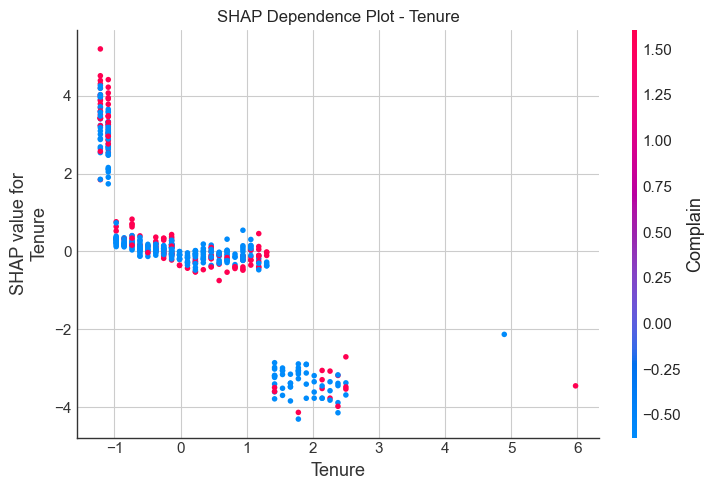

<Figure size 1000x600 with 0 Axes>

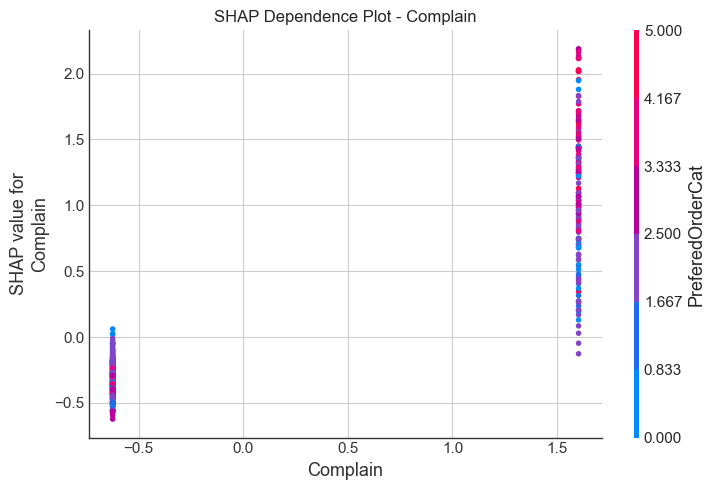

<Figure size 1000x600 with 0 Axes>

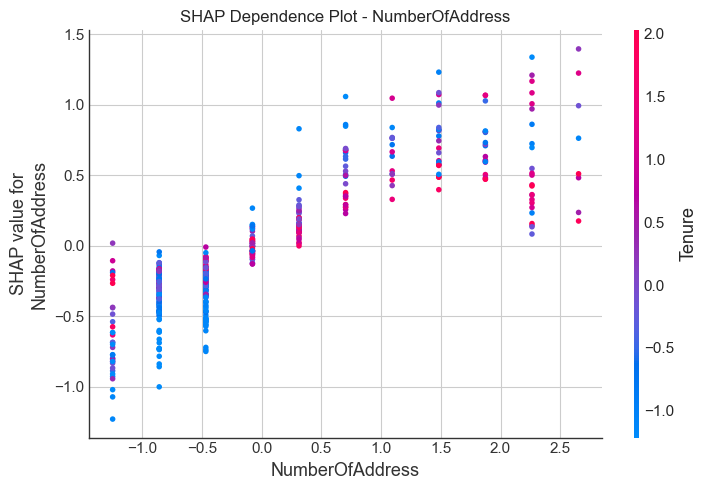

In [33]:
# Dependence plots for top 3 features
if len(shap_values.shape) == 3:
    mean_abs_shap = np.abs(shap_values.values[:, :, 1]).mean(axis=0)
else:
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

top_features_idx = np.argsort(mean_abs_shap)[-3:][::-1]
top_features = [X_sample.columns[i] for i in top_features_idx]

print(f"Top 3 features by SHAP importance: {top_features}")

for feature in top_features:
    plt.figure(figsize=(10, 6))
    if len(shap_values.shape) == 3:
        shap.dependence_plot(feature, shap_values.values[:, :, 1], X_sample, show=False)
    else:
        shap.dependence_plot(feature, shap_values.values, X_sample, show=False)
    plt.title(f'SHAP Dependence Plot - {feature}')
    plt.tight_layout()
    plt.savefig(f'../reports/figures/shap_dependence_{feature}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [34]:
# Save SHAP feature importance to CSV
feature_importance_shap = pd.DataFrame({
    'feature': X_sample.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

feature_importance_shap.to_csv('../reports/figures/shap_feature_importance.csv', index=False)

print("\nTop 10 Features by SHAP Importance:")
print(feature_importance_shap.head(10).to_string(index=False))


Top 10 Features by SHAP Importance:
          feature  mean_abs_shap
           Tenure       1.186718
         Complain       0.556162
  NumberOfAddress       0.372364
   CashbackAmount       0.339929
         CityTier       0.272423
    MaritalStatus       0.263678
SatisfactionScore       0.253280
    ActivityLevel       0.236256
  WarehouseToHome       0.211438
 PreferedOrderCat       0.208538


## 8. Inference

In [35]:
# Load best model for inference
model = joblib.load('../models/best_model.joblib')

# Make predictions on test set
predictions = model.predict(X_test_scaled)
probabilities = model.predict_proba(X_test_scaled)[:, 1]

# Create results DataFrame
inference_results = pd.DataFrame({
    'prediction': predictions,
    'churn_probability': probabilities,
    'risk_level': pd.cut(probabilities, bins=[0, 0.3, 0.6, 1.0], labels=['Low', 'Medium', 'High'])
})

# Combine with original features for context
inference_results = pd.concat([X_test_scaled.reset_index(drop=True), inference_results], axis=1)

# Save predictions
inference_results.to_csv('../data/processed/predictions.csv', index=False)

print("Inference Summary:")
print(f"  Total samples: {len(inference_results)}")
print(f"  Predicted churners: {(predictions == 1).sum()} ({(predictions == 1).mean():.1%})")
print(f"  Predicted non-churners: {(predictions == 0).sum()} ({(predictions == 0).mean():.1%})")
print(f"  Average churn probability: {probabilities.mean():.2%}")
print(f"\nRisk Level Distribution:")
print(inference_results['risk_level'].value_counts().to_string())

Inference Summary:
  Total samples: 1126
  Predicted churners: 174 (15.5%)
  Predicted non-churners: 952 (84.5%)
  Average churn probability: 16.70%

Risk Level Distribution:
risk_level
Low       916
High      154
Medium     56


In [36]:
# Show high-risk customers
high_risk = inference_results[inference_results['risk_level'] == 'High']
print(f"\nHigh-Risk Customers: {len(high_risk)}")
print(f"Average churn probability for high-risk: {high_risk['churn_probability'].mean():.2%}")


High-Risk Customers: 154
Average churn probability for high-risk: 84.31%


## Summary

This notebook demonstrates the complete churn prediction pipeline:

1. **Data Preparation**: Loaded from 'E Comm' sheet, handled missing values
2. **Feature Engineering**: Created 4 derived features, encoded categoricals
3. **Model Training**: Trained with MLflow tracking (Random Forest + optional XGBoost/LightGBM)
4. **Model Evaluation**: Confusion matrix, ROC curves, feature importance
5. **SHAP Analysis**: Waterfall, Force, Summary, Beeswarm, and Dependence plots
6. **Inference**: Risk-level predictions

### Generated Outputs
- `models/best_model.joblib` - Trained model
- `models/encoders.joblib` - Label encoders
- `models/scaler.joblib` - Feature scaler
- `data/processed/` - Train/test datasets and predictions
- `reports/figures/` - All visualization plots
- `mlruns/` - MLflow experiment tracking data

### Next Steps
- Run `mlflow ui` to view experiment results in browser